# How to use Candidate class in Your to analyze candidates

In [1]:
from your.candidate import Candidate
from your.utils.plotter import plot_h5
import numpy as np
from scipy.signal import detrend
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
%matplotlib inline

In [2]:
import pylab as plt
import logging
logger = logging.getLogger()
logger = logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -'
                                                        ' %(message)s')

First, we make the candiate object with the relevant paramters of the candidate.

In [3]:
# creating the candidate object with a certain dm, label, snr, tcand and width
fits_file = os.path.join('../tests/data/28.fits')
cand = Candidate(fp=fits_file, dm=475.28400, tcand=2.0288800, width=2, label=-1, snr=16.8128, min_samp=256, device=0)

In [4]:
# Get data, this will take data from the filterbank file, and can be accessed from cand.data:
cand.get_chunk()
print(cand.data, cand.data.shape,cand.dtype)

[[124 114 143 ... 145 118 159]
 [108 158 129 ... 122 142 158]
 [122 123 131 ... 119 142 129]
 ...
 [114 113 142 ... 120 141 160]
 [120 113 103 ... 146 107 136]
 [139 133 113 ... 146 141 160]] (991, 336) <class 'numpy.uint8'>


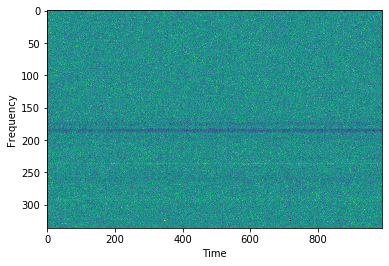

In [5]:
# here is our dispersed pulse
plt.imshow(cand.data.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [6]:
# Now let's make the DM Time plot. This may take a while. 
cand.dmtime()

Using <class 'str'>:
../tests/data/28.fits

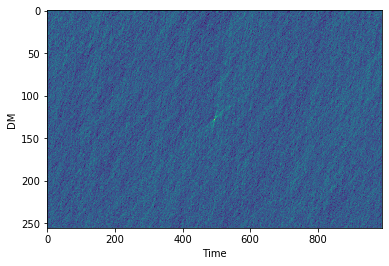

In [7]:
# the DM time plot can be accessed using cand.dmt. Let's have a look: 
plt.imshow(cand.dmt, aspect='auto',interpolation=None)
plt.ylabel('DM')
plt.xlabel('Time')
plt.show()

In [8]:
# Now let's Dedisperse it!
cand.dedisperse()

Using <class 'str'>:
../tests/data/28.fits

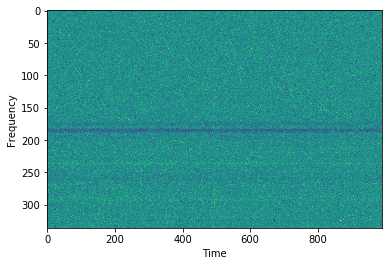

In [9]:
# The dedispersed pulse can be obtained using cand.dedispersed
plt.imshow(cand.dedispersed.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

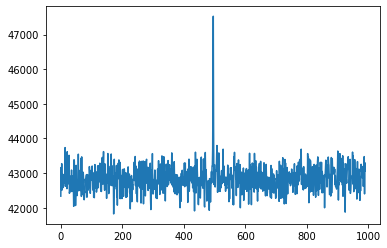

In [10]:
plt.plot(cand.dedispersed.T.sum(0))

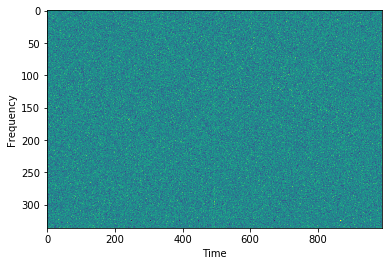

In [11]:
# Detrending can be used to remove bandpass variations
plt.imshow(detrend(cand.dedispersed.T),aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

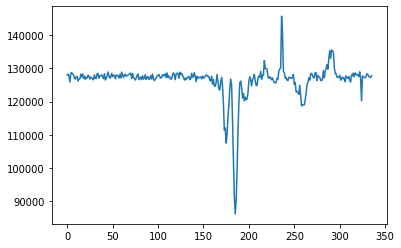

In [12]:
# Without detrend
plt.plot(cand.dedispersed.T.sum(1))

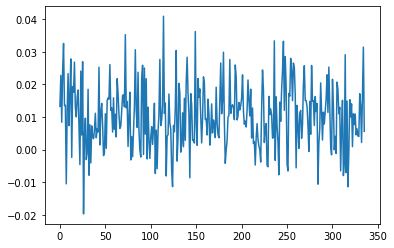

In [13]:
# With detrend
plt.plot(detrend(cand.dedispersed.T).sum(1))

In [14]:
# Optimise dm could be used to obtain accurate value of dm, and snr at that dm (under testing)
cand.optimize_dm()
print(f'Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}')
print(f'Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}')

Heimdall reported dm: 475.284, Optimised DM: 474.7613272736851
Heimdall reported snr: 16.8128, SNR at Opt. DM: 14.077508926391602


In [15]:
# for now, let's enter some random values for dm_opt and snr_opt
cand.dm_opt = -1
cand.snr_opt = -1

In [16]:
# Name of the candidate
cand.id

'cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280'

In [17]:
# Now let's save our candidate in an h5
fout=cand.save_h5()
print(fout) 

2020-08-21 13:00:29,236 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


2020-08-21 13:00:30,227 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

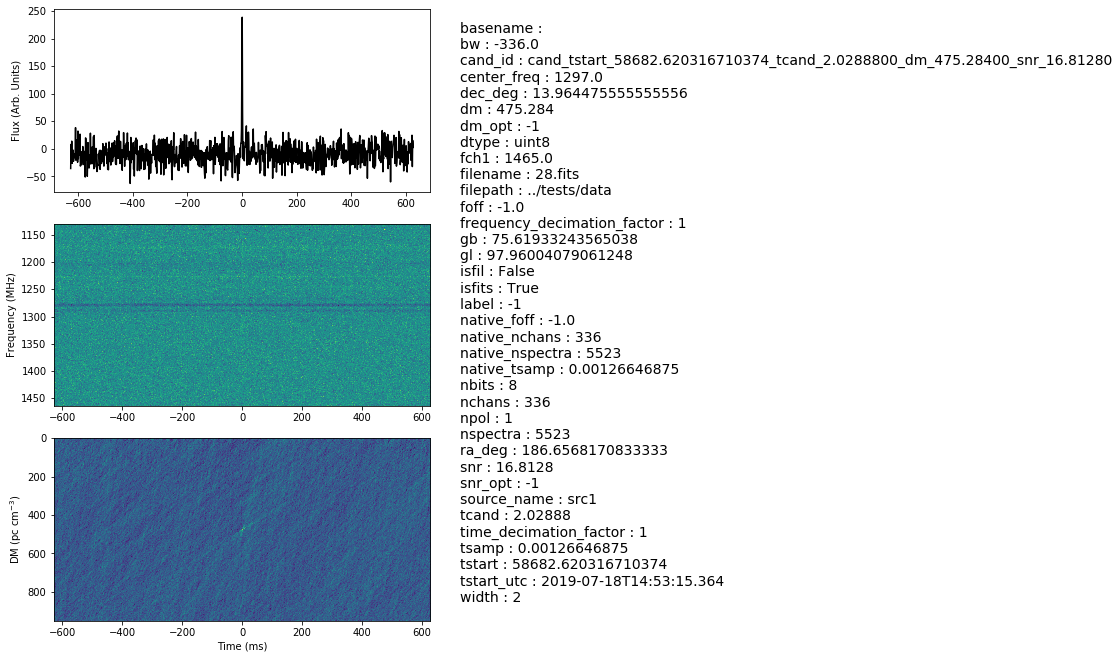

In [18]:
# We will use plot_h5 to plot the candidate h5 we just generated
plot_h5(fout, detrend_ft=False, save=True)

# Reshaping Freq-time and DM-time arrays

In [19]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [20]:
print(f'Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}')
print(f'Shape of DM-time data: {dmt_bkup.shape}')

Shape of dedispersed (frequency-time) data: (336, 991)
Shape of DM-time data: (256, 991)


In [21]:
time_size = 256
freq_size = 256

# Using resize in skimage.transform for reshaping

In [22]:
#resize dedispersed Frequency-time array along frequency axis
logging.info(f'Resizing time axis')
cand.resize(key='ft', size=time_size, axis=0, anti_aliasing=True)
logging.info(f'Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}')

#resize dedispersed Frequency-time array along time axis
logging.info(f'Resizing frequency axis')
cand.resize(key='ft', size=freq_size, axis=1, anti_aliasing=True)
logging.info(f'Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}')

2020-08-21 13:00:31,738 - root - MainThread - INFO - Resizing time axis
/home/kshitij/anaconda3/envs/grbfrb/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
2020-08-21 13:00:31,746 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (336, 256)
2020-08-21 13:00:31,747 - root - MainThread - INFO - Resizing frequency axis
2020-08-21 13:00:31,751 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (256, 256)


In [23]:
#resize DM-time array along time axis
cand.resize(key='dmt', size = time_size, axis=1, anti_aliasing=True)
logging.info(f'Shape of DM-time data after resizing: {cand.dmt.shape}')

2020-08-21 13:00:31,760 - root - MainThread - INFO - Shape of DM-time data after resizing: (256, 256)


# Using decimate for reshaping

In [24]:
from candidate import crop

In [25]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [26]:
logging.info(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

2020-08-21 13:00:31,783 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data: (336, 991)


In [27]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2  

freq_decimation_factor = cand.dedispersed.shape[1]//freq_size    
logging.info(f'Time decimation factor is {time_decimate_factor}')
logging.info(f'Frequency decimation factor is {freq_decimation_factor}')

2020-08-21 13:00:31,789 - root - MainThread - INFO - Time decimation factor is 1
2020-08-21 13:00:31,790 - root - MainThread - INFO - Frequency decimation factor is 1


Let's set the factors to something more interesting than 1

In [28]:
time_decimate_factor = 2
frequency_decimate_factor = 2

In [29]:
# Decimating time axis, and cropping to the final size
cand.decimate(key='ft', axis=0, pad=True, decimate_factor=time_decimate_factor, mode='median')
logging.info(f'Shape of dedispersed (frequency-time) data after time decimation: {cand.dedispersed.T.shape}')

# Cropping the time axis to a required size
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)
logging.info(f'Shape of dedispersed (frequency-time) data after time decimation + crop: {cand.dedispersed.T.shape}')

# Decimating frequency axis
cand.decimate(key='ft', axis=1, pad=True, decimate_factor=frequency_decimate_factor, mode='median')
logging.info(f'Shape of dedispersed (frequency-time) data after decimation: {cand.dedispersed.T.shape}')

2020-08-21 13:00:31,801 - your.utils.misc - MainThread - INFO - padding along axis 0
2020-08-21 13:00:31,808 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation: (336, 496)
2020-08-21 13:00:31,809 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation + crop: (336, 256)
2020-08-21 13:00:31,810 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after decimation: (168, 256)


In [30]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size 
logging.info(f'Original shape of DM-time data after time decimation: {cand.dmt.shape}')
cand.decimate(key='dmt', axis=1, pad=True, decimate_factor=time_decimate_factor, mode='median')
logging.info(f'Shape of DM-time data after time decimation: {cand.dmt.shape}')

crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)

logging.info(f'Shape of DM-time data after time decimation + crop: {cand.dmt.shape}')

2020-08-21 13:00:31,816 - root - MainThread - INFO - Original shape of DM-time data after time decimation: (256, 991)
2020-08-21 13:00:31,817 - your.utils.misc - MainThread - INFO - padding along axis 1
2020-08-21 13:00:31,824 - root - MainThread - INFO - Shape of DM-time data after time decimation: (256, 496)
2020-08-21 13:00:31,825 - root - MainThread - INFO - Shape of DM-time data after time decimation + crop: (256, 256)


Let's take a final look at the data. Decimation reduces the standard deviation of the data so the candidates should look more significant now. 

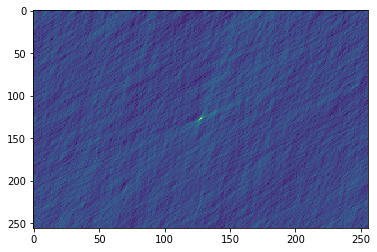

In [31]:
plt.imshow(cand.dmt, aspect='auto')

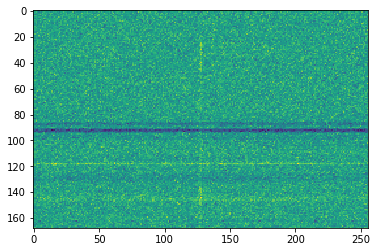

In [32]:
plt.imshow(cand.dedispersed.T, aspect='auto')

We can save this decimated data to h5 files using the same command as before

In [33]:
fout=cand.save_h5()
fout

2020-08-21 13:00:32,218 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


'cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5'

2020-08-21 13:00:32,308 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

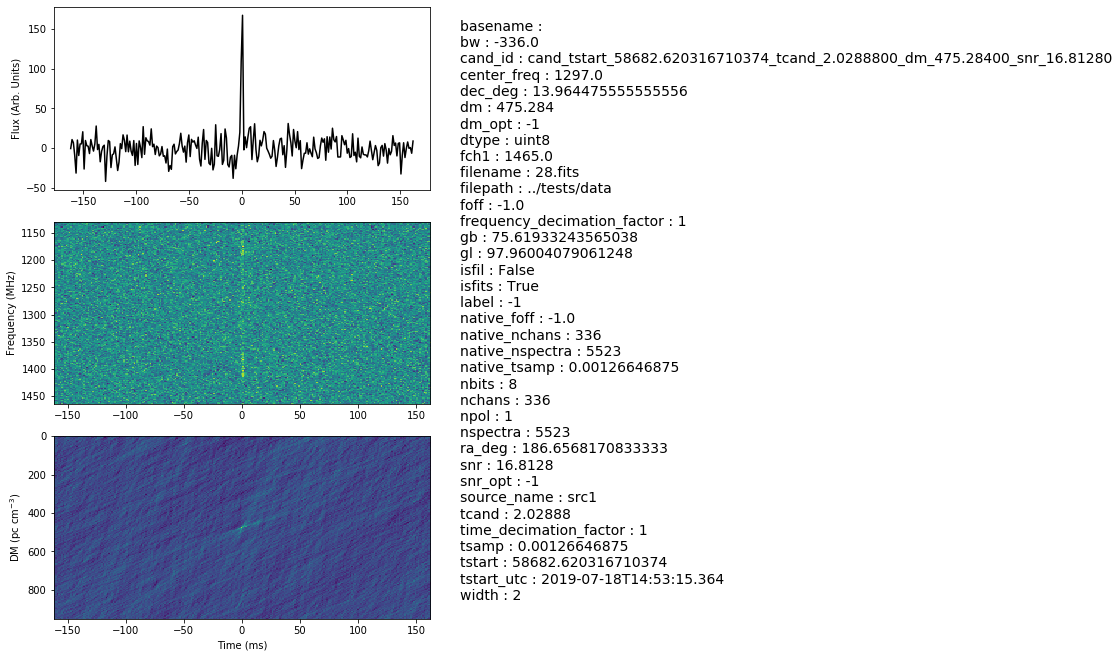

In [34]:
# Let's also detrend to remove the bandpass variations
plot_h5(fout, detrend_ft=True, save=True)